In [17]:
import json, glob, re, pycm, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, scipy.stats as sts
from IPython.display import display, Markdown

In [18]:
EXPERIMENT_RUN_VERSION = "v13"
BENCHMARK_SIZE = 1000.

In [19]:
def display_cms(cms):
    fig = plt.figure(figsize=(20,14))
    gs = fig.add_gridspec(4, 5, hspace=0.5)
    axes = gs.subplots()
    for ax, (name, cm) in zip(axes.flat, cms):
        df = pd.DataFrame(cm.matrix).T.fillna(0)
        sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
        ax.set_title(name, wrap=True, fontsize=9)
        ax.set(xlabel='Predicted', ylabel='Actual')
    for ax in axes.flat[len(cms):]:
        ax.set_visible(False)
    plt.show()

In [20]:
def unilateral_truth_value_distribution(df):
    model_evals = df.groupby('model_name')['evaluation'].value_counts().unstack(fill_value=0)
    for stat in ["t","f","n"]:
        if stat not in model_evals:
            model_evals[stat] = 0
    model_evals["t"] = model_evals["t"] / float(BENCHMARK_SIZE)
    model_evals["n"] = model_evals["n"] / float(BENCHMARK_SIZE)
    model_evals["f"] = model_evals["f"] / float(BENCHMARK_SIZE)
    return model_evals[["t", "n", "f"]]

In [21]:
def bilateral_truth_value_distribution(df):
    model_evals = df.groupby('model_name')['evaluation'].value_counts().unstack(fill_value=0)
    for stat in ["t","f","n", "b"]:
        if stat not in model_evals:
            model_evals[stat] = 0
    model_evals["t"] = model_evals["t"] / float(BENCHMARK_SIZE)
    model_evals["b"] = model_evals["b"] / float(BENCHMARK_SIZE)
    model_evals["n"] = model_evals["n"] / float(BENCHMARK_SIZE)
    model_evals["f"] = model_evals["f"] / float(BENCHMARK_SIZE)
    return model_evals[["t", "n", "b",  "f"]]

In [22]:
def plot_f1_comparison(df, n, figsize=(15, 6)):
    # Set the colors
    unilateral_color = '#8884d8'
    bilateral_color = '#82ca9d'

    # Create figure with larger size
    plt.figure(figsize=figsize)

    # Calculate bar positions
    x = np.arange(len(df))
    width = 0.35

    # Create bars
    bars1 = plt.bar(x - width/2, df['unilateral F1 macro'], width, label='Unilateral', color=unilateral_color, alpha=0.8)
    bars2 = plt.bar(x + width/2, df['bilateral F1 macro'], width, label='Bilateral', color=bilateral_color, alpha=0.8)

    # Set y-axis limits
    plt.ylim(0, 1.0)

    # Add value labels on top of bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom')

    autolabel(bars1)
    autolabel(bars2)

    # Customize the plot
    plt.ylabel('F1 macro (given attempted)', fontsize=12)
    plt.title(f'Unilateral vs Bilateral Evaluation (N={int(n):d})', fontsize=14, pad=20)
    plt.xticks(x, df['model'], rotation=45, ha='right')

    # Adjust layout to prevent label cutoff
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()

    plt.show()

In [23]:
cms = {}
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/unilateral/*.json"):
    model = re.match(r'.*/unilateral/(.*)-simpleqa.json', file).group(1)
    if model not in cms:
        cms[model] = {}
    df = pd.DataFrame.from_records(json.load(open(file, "r"))).query('evaluation == "t" or evaluation == "f"')
    cms[model]["unilateral"] = pycm.ConfusionMatrix(df["label"].tolist(), df["evaluation"].tolist(), digit=2, classes=[ 't', 'f' ])
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/bilateral/*.json"):
    model = re.match(r'.*/bilateral/(.*)-simpleqa.json', file).group(1)
    if model not in cms:
        cms[model] = {}
    df = pd.DataFrame.from_records(json.load(open(file, "r"))).query('evaluation == "t" or evaluation == "f"')
    cms[model]["bilateral"] = pycm.ConfusionMatrix(df["label"].tolist(), df["evaluation"].tolist(), digit=2, classes=[ 't', 'f' ])

In [24]:
cms

{'claude-3-5-sonnet-20241022': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'nf-Llama-3.1-70b-instruct': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'claude-3-5-haiku-20241022': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'gemini-2.0-flash-001': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'nf-gpt-4o-mini': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'nf-Llama-3.1-8b-instruct': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'gemma-2-27b-it': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])}

In [25]:
stats = [ 
    {
        'model': model,
        'unilateral N': cms[model]["unilateral"].POP['t'], 
        'unilateral ACC': cms[model]["unilateral"].ACC_Macro, 
        'unilateral AUC': cms[model]["unilateral"].AUC['t'], 
        'unilateral F1 macro': cms[model]["unilateral"].F1_Macro,
        'bilateral N': cms[model]["bilateral"].POP['t'], 
        'bilateral ACC': cms[model]["bilateral"].ACC_Macro, 
        'bilateral AUC': cms[model]["bilateral"].AUC['t'], 
        'bilateral F1 macro': cms[model]["bilateral"].F1_Macro,
    } 
    for model in cms if "bilateral" in cms[model]
]
stats_df = pd.DataFrame(stats)
stats_df['delta F1'] = stats_df['bilateral F1 macro'] - stats_df['unilateral F1 macro']
stats_df['unilateral coverage'] = stats_df['unilateral N'].apply(lambda x: x / BENCHMARK_SIZE)
stats_df['bilateral coverage'] = stats_df['bilateral N'].apply(lambda x: x / BENCHMARK_SIZE)
stats_df = stats_df[[ 'model', 
                     'unilateral coverage', 'unilateral ACC', 'unilateral AUC', 'unilateral F1 macro', 
                     'bilateral coverage', 'bilateral ACC', 'bilateral AUC', 'bilateral F1 macro', 
                     'delta F1' ]].sort_values('delta F1', ascending=False)

In [26]:
columns = [
    ('', 'model'),
    ('unilateral', 'coverage'),
    ('unilateral', 'ACC'),
    ('unilateral', 'AUC'),
    ('unilateral', 'F1 macro'),
    ('bilateral', 'coverage'),
    ('bilateral', 'ACC'),
    ('bilateral', 'AUC'),
    ('bilateral', 'F1 macro'),
    ('', 'delta F1')
]

original_columns = ['model',
                   'unilateral coverage', 'unilateral ACC', 'unilateral AUC', 'unilateral F1 macro',
                   'bilateral coverage', 'bilateral ACC', 'bilateral AUC', 'bilateral F1 macro',
                   'delta F1']

df_new = stats_df[original_columns].copy()
df_new.columns = pd.MultiIndex.from_tuples(columns)
df_new = df_new.reset_index(drop=True)

df_new = df_new.style.format({
    ('', 'model'): '{}',
    ('unilateral', 'coverage'): '{:.3f}',
    ('unilateral', 'ACC'): '{:.3f}',
    ('unilateral', 'AUC'): '{:.3f}',
    ('unilateral', 'F1 macro'): '{:.3f}',
    ('bilateral', 'coverage'): '{:.3f}',
    ('bilateral', 'ACC'): '{:.3f}',
    ('bilateral', 'AUC'): '{:.3f}',
    ('bilateral', 'F1 macro'): '{:.3f}',
    ('', 'delta F1'): '{:.3f}'
})

In [27]:
unilateral_results = []
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/unilateral/*.json"):
   unilateral_results += json.load(open(file, "r"))
df_unilateral = pd.DataFrame(unilateral_results)
df_unilateral_tv_dist = unilateral_truth_value_distribution(df_unilateral)

In [28]:
bilateral_results = []
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/bilateral/*.json"):
   bilateral_results += json.load(open(file, "r"))
df_bilateral = pd.DataFrame(bilateral_results)
df_bilateral_tv_dist = bilateral_truth_value_distribution(df_bilateral)

# Performance by model

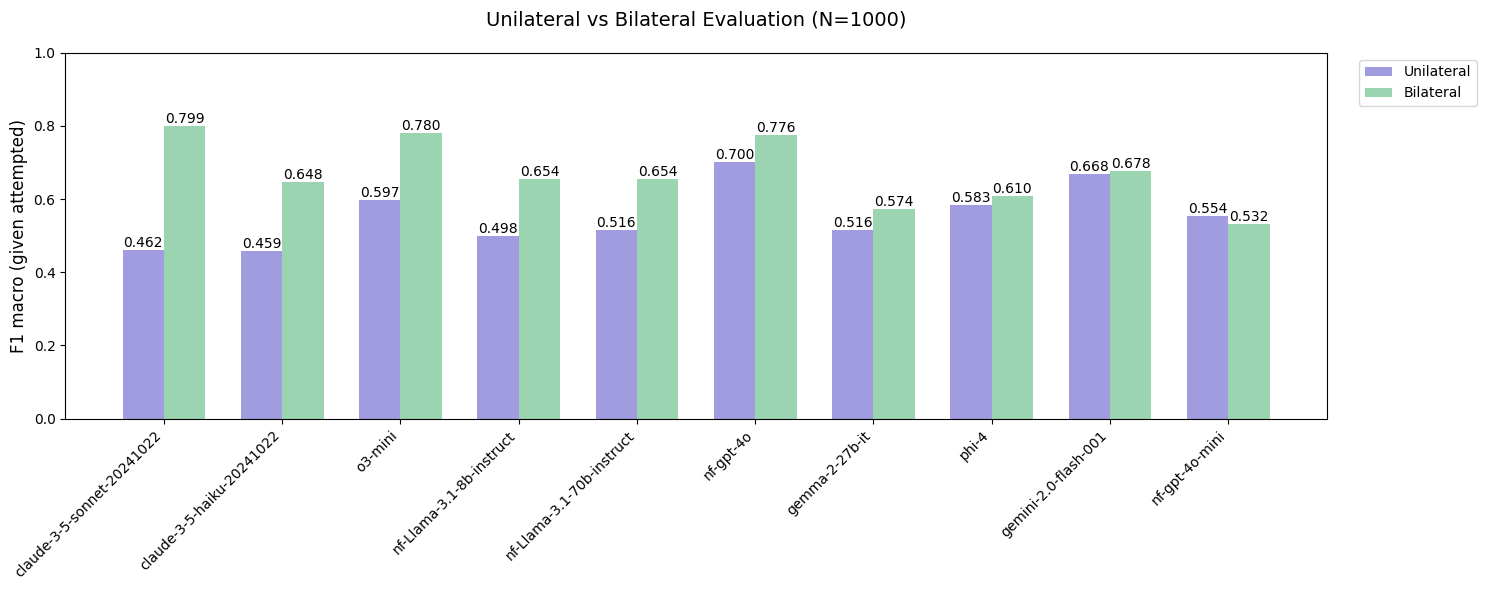

# Truth value distribution by model

## Unilateral

evaluation,t,n,f
model_name,,,
claude-3-5-haiku-20241022,0.121,0.000,0.879
claude-3-5-sonnet-20241022,0.086,0.000,0.914
google/gemini-2.0-flash-001,0.587,0.000,0.413
google/gemma-2-27b-it,0.254,0.003,0.743
microsoft/phi-4,0.453,0.000,0.547
nf-Llama-3.1-70b-instruct,0.209,0.007,0.784
nf-Llama-3.1-8b-instruct,0.216,0.013,0.771
nf-gpt-4o,0.435,0.000,0.565
nf-gpt-4o-mini,0.400,0.000,0.600


## Bilateral

evaluation,t,n,b,f
model_name,,,,
claude-3-5-haiku-20241022,0.086,0.456,0.010,0.034
claude-3-5-sonnet-20241022,0.059,0.222,0.023,0.112
google/gemini-2.0-flash-001,0.448,0.249,0.126,0.177
google/gemma-2-27b-it,0.141,0.510,0.002,0.021
microsoft/phi-4,0.061,0.070,0.075,0.073
nf-Llama-3.1-70b-instruct,0.152,0.632,0.002,0.035
nf-Llama-3.1-8b-instruct,0.083,0.878,0.000,0.039
nf-gpt-4o,0.273,0.235,0.171,0.321
nf-gpt-4o-mini,0.439,0.336,0.096,0.129


# Confusion matrices given attempted by model

## claude-3-5-sonnet-20241022

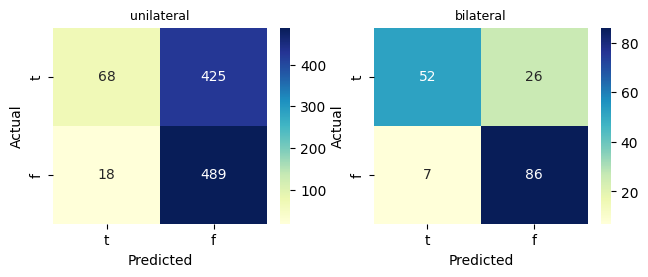

## nf-Llama-3.1-70b-instruct

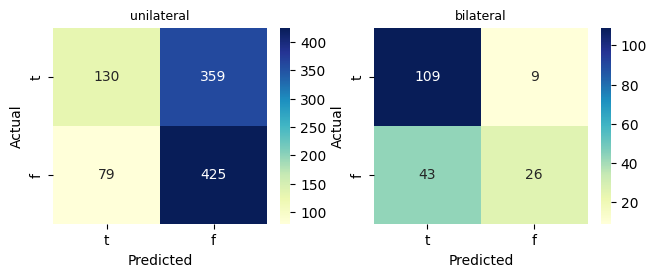

## claude-3-5-haiku-20241022

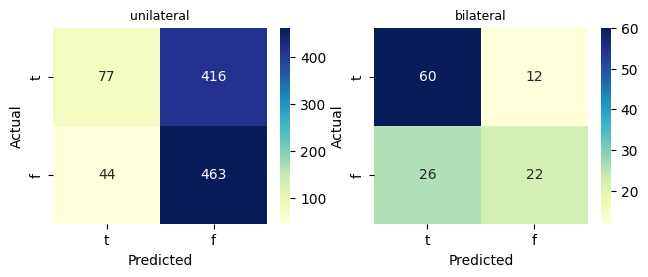

## gemini-2.0-flash-001

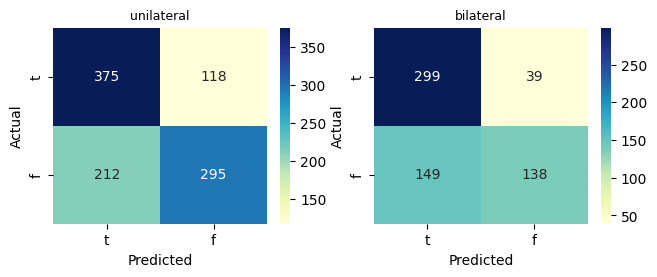

## nf-gpt-4o-mini

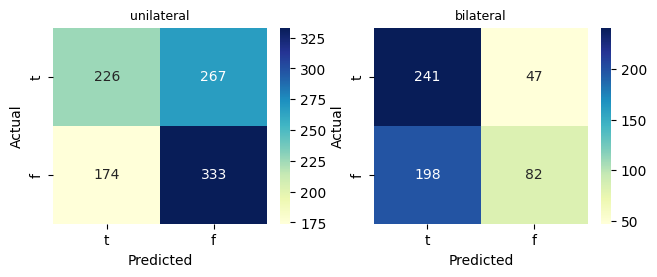

## nf-Llama-3.1-8b-instruct

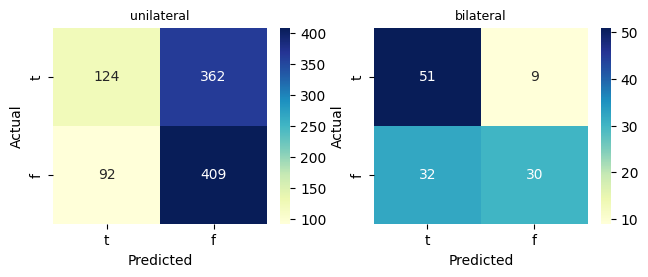

## gemma-2-27b-it

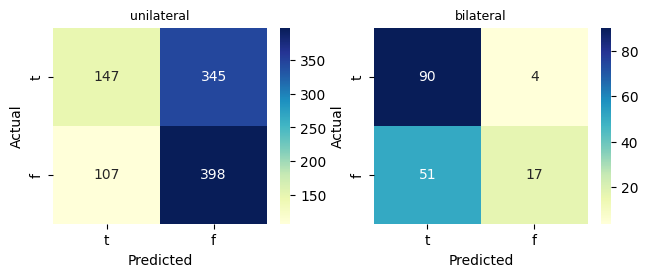

## o3-mini

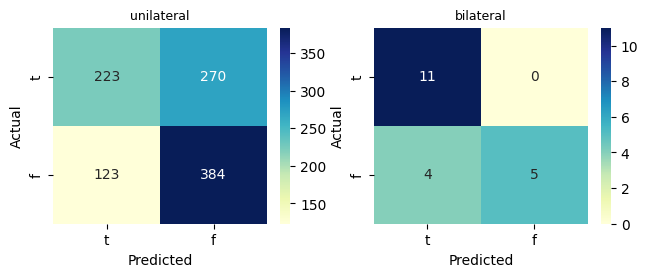

## phi-4

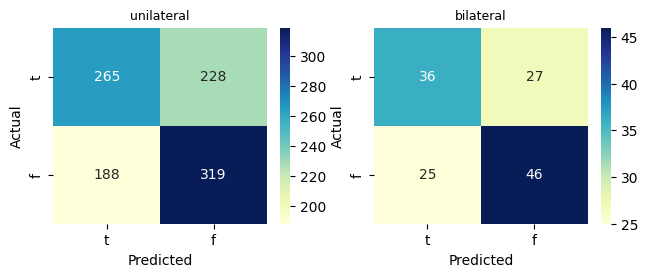

## nf-gpt-4o

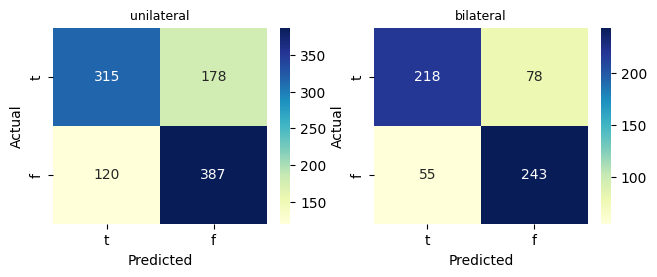

In [29]:
display(Markdown("# Performance by model"))
display(df_new)
plot_f1_comparison(stats_df, BENCHMARK_SIZE)
display(Markdown("# Truth value distribution by model"))
display(Markdown(f'## Unilateral'))
display(df_unilateral_tv_dist)
display(Markdown(f'## Bilateral'))
display(df_bilateral_tv_dist)
display(Markdown("# Confusion matrices given attempted by model"))
for model in cms:
    if "bilateral" in cms[model]:
        display(Markdown(f'## {model}'))
        display_cms([(f"unilateral", cms[model]["unilateral"]), (f"bilateral", cms[model]["bilateral"])])

In [30]:
stats_df

,model,unilateral coverage,unilateral ACC,unilateral AUC,unilateral F1 macro,bilateral coverage,bilateral ACC,bilateral AUC,bilateral F1 macro,delta F1
0,claude-3-5-sonnet-20241022,1.000,0.557000,0.551214,0.461568,0.171,0.807018,0.795699,0.799074,0.337507
2,claude-3-5-haiku-20241022,1.000,0.540000,0.534701,0.459462,0.120,0.683333,0.645833,0.648040,0.188578
7,o3-mini,1.000,0.607000,0.604865,0.596542,0.020,0.800000,0.777778,0.780220,0.183678
5,nf-Llama-3.1-8b-instruct,0.987,0.540020,0.535756,0.498179,0.122,0.663934,0.666935,0.653673,0.155494
1,nf-Llama-3.1-70b-instruct,0.993,0.558912,0.554551,0.516215,0.187,0.721925,0.650270,0.653704,0.137488
9,nf-gpt-4o,1.000,0.702000,0.701129,0.700447,0.594,0.776094,0.775961,0.775697,0.075250
6,gemma-2-27b-it,0.997,0.546640,0.543450,0.515961,0.162,0.660494,0.603723,0.573990,0.058029
8,phi-4,1.000,0.584000,0.583358,0.582783,0.134,0.611940,0.609658,0.609767,0.026984
3,gemini-2.0-flash-001,1.000,0.670000,0.671252,0.667874,0.625,0.699200,0.682726,0.677821,0.009947
4,nf-gpt-4o-mini,1.000,0.559000,0.557611,0.553893,0.568,0.568662,0.564831,0.531988,-0.021904


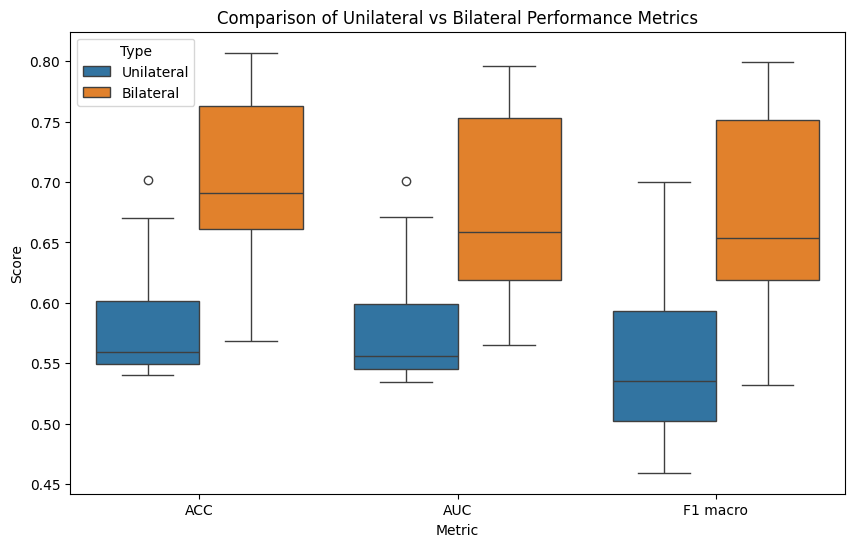

In [31]:
# Create long-format data for the three metrics (ACC, AUC, F1 macro)
unilateral_data = pd.DataFrame({
    'Metric': ['ACC'] * len(stats_df) + ['AUC'] * len(stats_df) + ['F1 macro'] * len(stats_df),
    'Value': stats_df['unilateral ACC'].tolist() + stats_df['unilateral AUC'].tolist() + stats_df['unilateral F1 macro'].tolist(),
    'Type': ['Unilateral'] * (len(stats_df) * 3)
})

bilateral_data = pd.DataFrame({
    'Metric': ['ACC'] * len(stats_df) + ['AUC'] * len(stats_df) + ['F1 macro'] * len(stats_df),
    'Value': stats_df['bilateral ACC'].tolist() + stats_df['bilateral AUC'].tolist() + stats_df['bilateral F1 macro'].tolist(),
    'Type': ['Bilateral'] * (len(stats_df) * 3)
})

# Combine the data
plot_data = pd.concat([unilateral_data, bilateral_data])

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Value', hue='Type', data=plot_data)
plt.title('Comparison of Unilateral vs Bilateral Performance Metrics')
plt.ylabel('Score')
plt.show()

In [32]:
# For ACC
uni_acc = stats_df['unilateral ACC']
bi_acc = stats_df['bilateral ACC']
stat_acc, p_acc = sts.mannwhitneyu(uni_acc, bi_acc, alternative='less')

# For AUC
uni_auc = stats_df['unilateral AUC']
bi_auc = stats_df['bilateral AUC']
stat_auc, p_auc = sts.mannwhitneyu(uni_auc, bi_auc, alternative='less')

# For F1 macro
uni_f1 = stats_df['unilateral F1 macro']
bi_f1 = stats_df['bilateral F1 macro']
stat_f1, p_f1 = sts.mannwhitneyu(uni_f1, bi_f1, alternative='less')

# Print results
print(f"ACC Mann-Whitney U test: statistic={stat_acc:.4f}, p-value={p_acc:.4f}")
print(f"AUC Mann-Whitney U test: statistic={stat_auc:.4f}, p-value={p_auc:.4f}")
print(f"F1 macro Mann-Whitney U test: statistic={stat_f1:.4f}, p-value={p_f1:.4f}")

ACC Mann-Whitney U test: statistic=12.0000, p-value=0.0023
AUC Mann-Whitney U test: statistic=16.0000, p-value=0.0057
F1 macro Mann-Whitney U test: statistic=18.0000, p-value=0.0086
